<a href="https://colab.research.google.com/github/rashikajakhmola/Migration-Trend-Analysis/blob/main/Spatio_temporal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Objectives

This project conducts a spatio-temporal analysis of border encounters at the U.S. southwest land border from 2000 to 2022. The dataset is sourced from the U.S. Customs and Border Protection (CBP) and includes monthly data on encounters for each border sector.

*   **Data Acquisition**: Collected monthly border encounter data from the CBP for
all sectors of the southwest border, including Big Bend, Del Rio, El Paso, Laredo, and Rio Grande Valley.
*   **Policy Analysis**: Investigated the impact of two policies:
1.   Title 42: A public health order that allowed border agents to expel migrants quickly during the COVID-19 pandemic.
2.   Remain in Mexico (Migrant Protection Protocols): A policy that required asylum seekers to remain in Mexico while their U.S. asylum cases were processed.


*   **Difference-in-Differences (DiD) Methodology**: Used a DiD approach to
estimate the causal effect of these policies on the number of border encounters, controlling for pre-existing trends.





# Results


1.   Post-policy periods showed a significant overall increase in border encounters, especially after the implementation of Title 42.

2.   Remain in Mexico demonstrated a positive effect on encounters initially, but its impact decreased in the post-policy period.

3. The Difference-in-Differences (DiD) model showed that Title 42 had a negative impact on border encounters, though the effect was not statistically significant in the model.






In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Spatio-temporal regression model

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/0. Job Search 2024/Project/Data/df_final.csv')

In [ ]:
# Convert 'Encounters' to numeric, removing commas
df['Encounters'] = pd.to_numeric(df['Encounters'].str.replace(',', ''), errors='coerce')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by sector and date
df = df.sort_values(by=['Sectors', 'Date'])

# Step 2: Create temporal lags (previous month's encounters)
df['Encounters_Lag1'] = df.groupby('Sectors')['Encounters'].shift(1)

# Drop rows with NaN values introduced by the lag
df = df.dropna(subset=['Encounters_Lag1'])

# Step 3: Create spatial lags by averaging the encounters from other sectors
# Pivot the data so each row represents a date and each column represents a sector
df_pivoted = df.pivot(index='Date', columns='Sectors', values='Encounters')

# Create spatial lags by averaging the encounters from neighboring sectors
for sector in df_pivoted.columns:
    df_pivoted[sector + '_Spatial_Lag'] = df_pivoted.drop(columns=sector).mean(axis=1)

# Melt the pivoted data back into long format to merge with the original dataframe
df_spatial_lag = df_pivoted.filter(like='_Spatial_Lag').reset_index().melt(id_vars='Date',
                                                                          var_name='Sectors',
                                                                          value_name='Spatial_Lag')

# Remove '_Spatial_Lag' from the sector names
df_spatial_lag['Sectors'] = df_spatial_lag['Sectors'].str.replace('_Spatial_Lag', '')

# Merge the spatial lag data back into the original dataframe
df = pd.merge(df, df_spatial_lag, on=['Date', 'Sectors'])

# Step 4: Prepare the data for regression
# Select the predictors (Encounters_Lag1 and Spatial_Lag)
X = df[['Encounters_Lag1', 'Spatial_Lag']]

# Select the target variable (current encounters)
y = df['Encounters']

# Add a constant term (intercept)
X = sm.add_constant(X)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Fit OLS model
model = sm.OLS(y_train, X_train).fit()

# Evaluate OLS model on the test set
y_pred_ols = model.predict(X_test)
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print(f"OLS - MSE: {mse_ols}, R-squared: {r2_ols}")

# Step 7: Fit Ridge regression model
ridge_model = Ridge(alpha=1.0)  # You can experiment with different values of alpha
ridge_model.fit(X_train, y_train)

# Make predictions on the test set using Ridge
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge - MSE: {mse_ridge}, R-squared: {r2_ridge}")

# Step 8: Fit Lasso regression model (optional)
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha for Lasso as well
lasso_model.fit(X_train, y_train)

# Make predictions on the test set using Lasso
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate Lasso model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso - MSE: {mse_lasso}, R-squared: {r2_lasso}")


OLS - MSE: 10961479.60164172, R-squared: 0.8349705493339257
Ridge - MSE: 10961479.601902736, R-squared: 0.834970549329996
Lasso - MSE: 10961479.651601013, R-squared: 0.8349705485817687


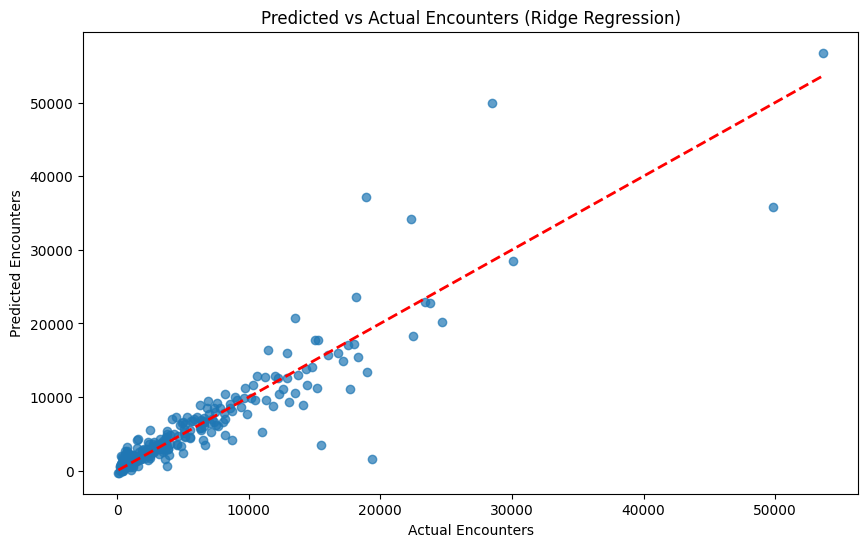

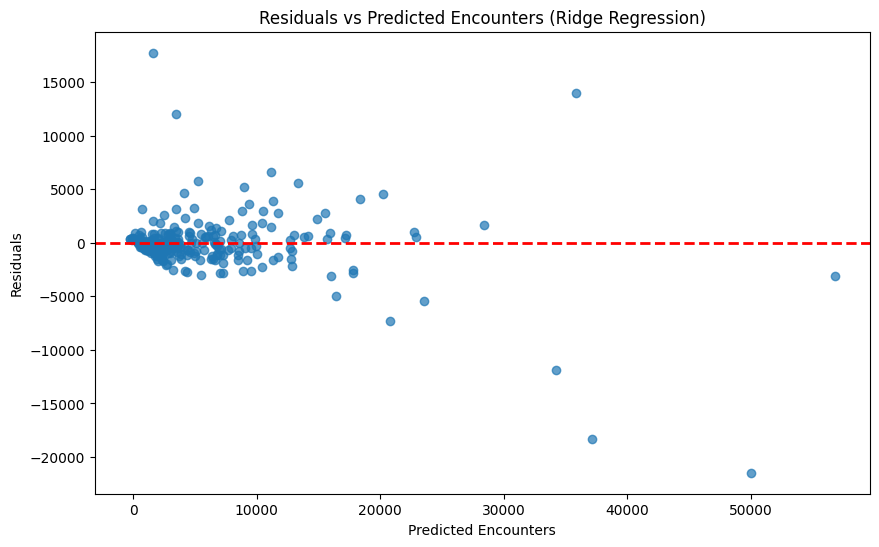

In [ ]:
import matplotlib.pyplot as plt

# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Encounters (Ridge Regression)')
plt.xlabel('Actual Encounters')
plt.ylabel('Predicted Encounters')
plt.show()

# Plot Residuals (difference between actual and predicted)
residuals = y_test - y_pred_ridge

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_ridge, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Encounters (Ridge Regression)')
plt.xlabel('Predicted Encounters')
plt.ylabel('Residuals')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Step 1: Convert 'Encounters' to numeric, removing commas
df['Encounters'] = pd.to_numeric(df['Encounters'].str.replace(',', ''), errors='coerce')

# Step 2: Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 3: Sort the data by sector and date
df = df.sort_values(by=['Sectors', 'Date'])

# Step 4: Create temporal lags (previous month's encounters)
df['Encounters_Lag1'] = df.groupby('Sectors')['Encounters'].shift(1)

# Step 5: Drop rows with NaN values introduced by the lag
df = df.dropna(subset=['Encounters_Lag1'])

# Step 6: Create spatial lags by averaging the encounters from other sectors
df_pivoted = df.pivot(index='Date', columns='Sectors', values='Encounters')

# Step 7: Create spatial lags by averaging the encounters from other sectors
for sector in df_pivoted.columns:
    df_pivoted[sector + '_Spatial_Lag'] = df_pivoted.drop(columns=sector).mean(axis=1)

# Step 8: Melt the pivoted data back into long format to merge with the original dataframe
df_spatial_lag = df_pivoted.filter(like='_Spatial_Lag').reset_index().melt(id_vars='Date',
                                                                          var_name='Sectors',
                                                                          value_name='Spatial_Lag')

# Step 9: Remove '_Spatial_Lag' from the sector names
df_spatial_lag['Sectors'] = df_spatial_lag['Sectors'].str.replace('_Spatial_Lag', '')

# Step 10: Merge the spatial lag data back into the original dataframe
df = pd.merge(df, df_spatial_lag, on=['Date', 'Sectors'])

# Step 11: Prepare the data for regression
X = df[['Encounters_Lag1', 'Spatial_Lag']]
y = df['Encounters']

# Step 12: Add a constant term for the intercept
X = sm.add_constant(X)

# Step 13: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 14: Fit a Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Step 15: Forecasting future encounters
forecast_horizon = 6  # Number of future periods to forecast

# Get the last available date in the dataset
last_date = df['Date'].max()

# Generate future dates
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')

# Get a list of all sectors
sectors = df['Sectors'].unique()

# Create a DataFrame for future dates and sectors
future_df = pd.DataFrame({'Date': np.repeat(future_dates, len(sectors)), 'Sectors': np.tile(sectors, len(future_dates))})

# Get the most recent lag data for each sector
recent_data = df.groupby('Sectors').tail(1)[['Sectors', 'Encounters', 'Spatial_Lag']]

# Merge recent data with future dates
future_df = pd.merge(future_df, recent_data, on='Sectors', how='left')

# Rename columns for consistency
future_df.rename(columns={'Encounters': 'Encounters_Lag1'}, inplace=True)

# Add a constant for prediction
X_future = sm.add_constant(future_df[['Encounters_Lag1', 'Spatial_Lag']])

# Make predictions using the trained Ridge model
future_df['Predicted_Encounters'] = ridge_model.predict(X_future)

# Display the future forecast
print(future_df[['Date', 'Sectors', 'Predicted_Encounters']])


         Date            Sectors  Predicted_Encounters
0  2023-01-01          Big Bend            2377.566912
1  2023-01-01            Del Rio          21524.196525
2  2023-01-01            El Paso           7728.660297
3  2023-01-01             Laredo           2147.093635
4  2023-01-01  Rio Grande Valley          23403.016436
5  2023-02-01          Big Bend            2377.566912
6  2023-02-01            Del Rio          21524.196525
7  2023-02-01            El Paso           7728.660297
8  2023-02-01             Laredo           2147.093635
9  2023-02-01  Rio Grande Valley          23403.016436
10 2023-03-01          Big Bend            2377.566912
11 2023-03-01            Del Rio          21524.196525
12 2023-03-01            El Paso           7728.660297
13 2023-03-01             Laredo           2147.093635
14 2023-03-01  Rio Grande Valley          23403.016436
15 2023-04-01          Big Bend            2377.566912
16 2023-04-01            Del Rio          21524.196525
17 2023-04

# ConvLSTM

In [65]:
data = pd.read_csv('/content/drive/MyDrive/0. Job Search 2024/Project/Data/df_final.csv')

Input shape: (1056, 12, 2, 3, 11)
Target shape: (1056,)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0069 - val_loss: 0.0355
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0026 - val_loss: 0.0352
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0029 - val_loss: 0.0346
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0025 - val_loss: 0.0286
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026 - val_loss: 0.0326
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 0.0318
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0026 - val_loss: 0.0336
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 0.0292
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0312
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 0.0318


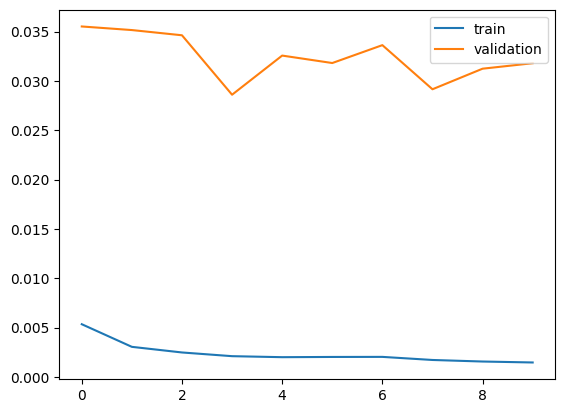

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


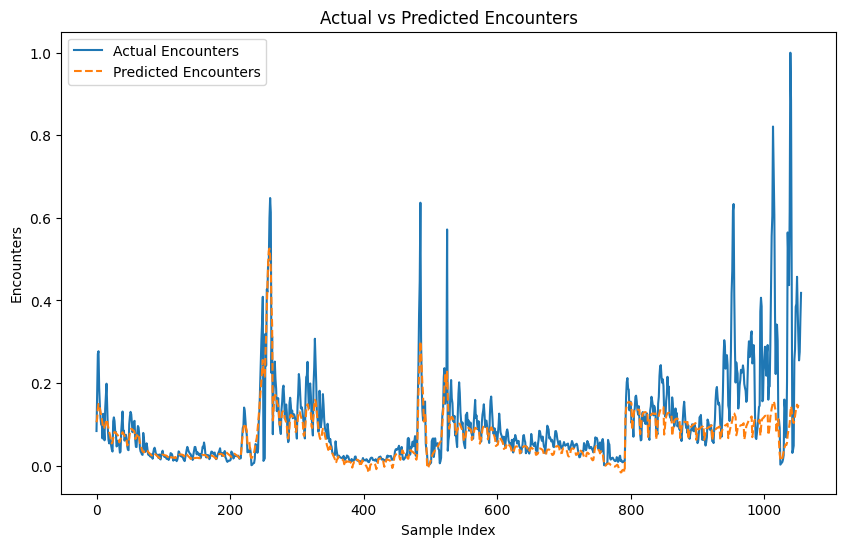

In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime type and 'Encounters' to numeric
data['Date'] = pd.to_datetime(data['Date'])
data['Encounters'] = pd.to_numeric(data['Encounters'].str.replace(',', ''), errors='coerce')

# Drop the 'Year' column and any rows with missing values
data_clean = data.drop(columns=['Year']).dropna()

# Columns to scale (excluding 'Date' and 'Sectors')
columns_to_scale = ['Encounters', 'title42', 'remain_in_mexico', 'Mexico_COVID_Cases',
                    'Guatemala_COVID_Cases', 'Honduras_COVID_Cases', 'ElSalvador_COVID_Cases',
                    'Mexico_Unemployment', 'Honduras_Unemployment', 'Guatemala_Unemployment', 'ElSalvador_Unemployment']

# Initialize a scaler
scaler = MinMaxScaler()

# Apply scaling to the relevant columns
data_clean[columns_to_scale] = scaler.fit_transform(data_clean[columns_to_scale])

# Group by sector and date, excluding non-numeric columns
data_grouped = data_clean.groupby(['Sectors', 'Date']).mean(numeric_only=True).reset_index()

# Define the spatial grid for 5 sectors (arranged in a 2x3 grid, with one empty slot)
sector_grid = {
    'Big Bend': (0, 0), 'Del Rio': (0, 1), 'El Paso': (0, 2),
    'Laredo': (1, 0), 'Rio Grande Valley': (1, 1)  # One slot left empty at (1, 2)
}

# Set the time window
time_window = 12

# Initialize empty grids
X_grid = []
y_grid = []

# Loop through each sector and create spatial-temporal sequences
for sector, (i, j) in sector_grid.items():
    sector_data = data_grouped[data_grouped['Sectors'] == sector].sort_values(by='Date')
    encounters_series = sector_data[columns_to_scale].values
    sector_sequences = [encounters_series[k:k+time_window] for k in range(len(encounters_series) - time_window)]

    # For each sequence, add the data to the correct grid location
    for seq in sector_sequences:
        grid = np.zeros((time_window, 2, 3, len(columns_to_scale)))  # 2x3 grid
        grid[:, i, j, :] = seq  # Assign data to the appropriate position in the grid
        X_grid.append(grid)
        y_grid.append(seq[-1, 0])  # Predict the next step's 'Encounters'

# Convert to numpy arrays
X_grid = np.array(X_grid)
y_grid = np.array(y_grid)

# Print the shapes to verify
print("Input shape:", X_grid.shape)
print("Target shape:", y_grid.shape)

# Build the ConvLSTM Model
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', input_shape=(time_window, 2, 3, len(columns_to_scale))),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)  # Output layer for predicting 'Encounters'
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_grid, y_grid, epochs=10, batch_size=32, validation_split=0.2)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_grid)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_grid, label='Actual Encounters')
plt.plot(predictions, label='Predicted Encounters', linestyle='--')
plt.title('Actual vs Predicted Encounters')
plt.xlabel('Sample Index')
plt.ylabel('Encounters')
plt.legend()
plt.show()


# DiD Analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/0. Job Search 2024/Project/Data/df_final.csv')

<ipython-input-42-cbcc9569a2d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Encounters'] = df_filtered['Encounters'].replace(',', '', regex=True).astype(int)
<ipython-input-42-cbcc9569a2d6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Policy'] = np.where((df_filtered['title42'] == 1) | (df_filtered['remain_in_mexico'] == 1), 'Post-Policy', 'Pre-Policy')
<ipython-input-42-cbcc9569a2d6>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

                            OLS Regression Results                            
Dep. Variable:             Encounters   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     7.618
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           8.10e-05
Time:                        21:57:58   Log-Likelihood:                -1919.9
No. Observations:                 180   AIC:                             3848.
Df Residuals:                     176   BIC:                             3861.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9727.5556   2473.219      3.933      

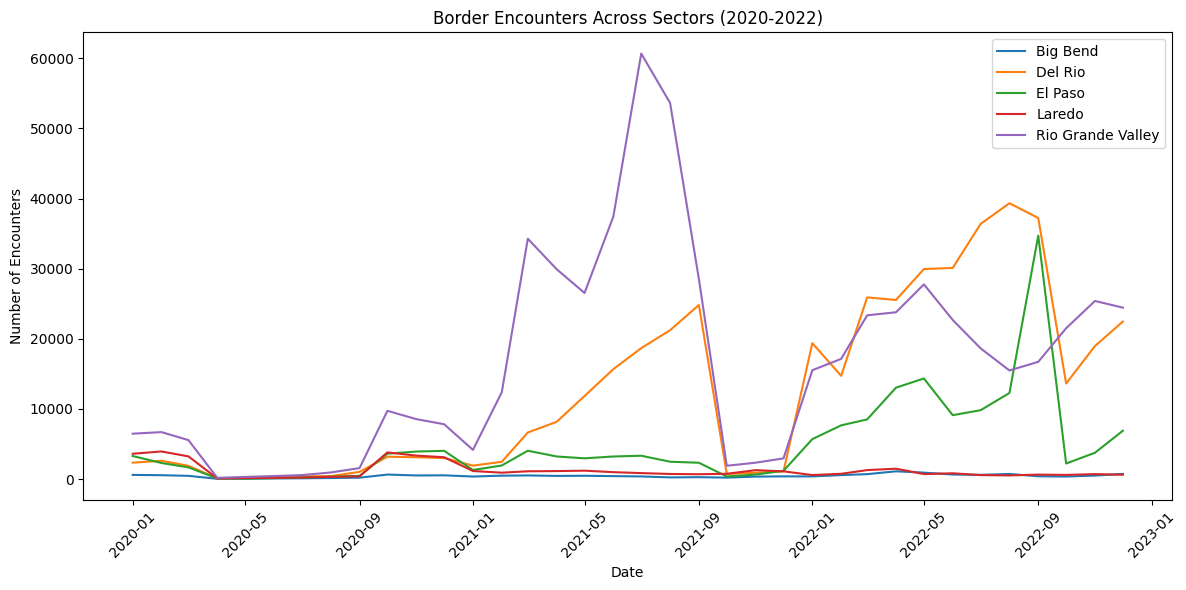

In [ ]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter the data for the period from 2020 to 2022
df_filtered = df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2022-12-31')]

# Remove commas from 'Encounters' and convert to numeric
df_filtered['Encounters'] = df_filtered['Encounters'].replace(',', '', regex=True).astype(int)

# Create a 'Policy' column to mark the presence of either Title 42 or Remain in Mexico
df_filtered['Policy'] = np.where((df_filtered['title42'] == 1) | (df_filtered['remain_in_mexico'] == 1), 'Post-Policy', 'Pre-Policy')

# Spatio-temporal analysis: Aggregate encounters by sector and period (Pre/Post Policy)
sector_policy_analysis = df_filtered.groupby(['Sectors', 'Policy']).agg({
    'Encounters': 'sum'
}).reset_index()

# Perform a Difference-in-Differences (DiD) analysis
# Create a DiD model with 'Encounters' as the dependent variable and 'Policy' and 'Sectors' as independent variables
df_filtered['PostPolicy'] = np.where(df_filtered['Policy'] == 'Post-Policy', 1, 0)
df_filtered['Treatment'] = np.where(df_filtered['Sectors'].isin(['Rio Grande Valley', 'El Paso']), 1, 0)  # Example treatment sectors

# Difference-in-Differences model
df_filtered['Interaction'] = df_filtered['PostPolicy'] * df_filtered['Treatment']

model = ols('Encounters ~ PostPolicy + Treatment + Interaction', data=df_filtered).fit()

# Output model summary
print(model.summary())

# Plotting the spatio-temporal patterns
plt.figure(figsize=(12, 6))
for sector in df_filtered['Sectors'].unique():
    sector_data = df_filtered[df_filtered['Sectors'] == sector].groupby('Date').agg({'Encounters': 'sum'}).reset_index()
    plt.plot(sector_data['Date'], sector_data['Encounters'], label=sector)

plt.title('Border Encounters Across Sectors (2020-2022)')
plt.xlabel('Date')
plt.ylabel('Number of Encounters')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Here's a quick analysis of the model output:

Intercept (9727.56): This is the base number of encounters when no policy (pre-policy) and no treatment (non-treatment sectors) are considered.

PostPolicy (-6041.59): This coefficient suggests that after the policy is enacted, border encounters decreased by around 6041 encounters on average across all sectors. This result is statistically significant at the 5% level (p-value = 0.027).

Treatment (6266.61): Sectors identified as part of the treatment group (e.g., Rio Grande Valley, El Paso) have slightly more encounters compared to other sectors, but this is not statistically significant (p-value = 0.111).

Interaction (-290.86): This measures the combined effect of being in the post-policy period and in a treatment sector. The coefficient is not statistically significant, suggesting that there is no strong evidence that the policy had a differential impact in treatment sectors compared to non-treatment sectors.

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)
['Fiji' 'United Republic of Tanzania' 'Western Sahara' 'Canada'
 'United States of America' 'Kazakhstan' 'Uzbekistan' 'Papua New Guinea'
 'Indonesia' 'Argentina' 'Chile' 'Democratic Republic of the Congo'
 'Somalia' 'Kenya' 'Sudan' 'Chad' 'Haiti' 'Dominican Republic' 'Russia'
 'The Bahamas' 'Falkland Islands' 'Norway' 'Greenland'
 'French Southern and Antarctic Lands' 'East Timor' 'South Africa'
 'Lesotho' 'Mexico' 'Uruguay' 'Brazil' 'Bolivia' 'Peru' 'Colombia'
 'Panama' 'Costa Rica' 'Nicaragua' 'Honduras' 'El Salvador' 'Guatemala'
 'Belize' 'Venezuela' 'Guyana' 'Suriname' 'France' 'Ecuador' 'Puerto Rico'
 'Jamaica' 'Cuba' 'Zimbabwe' 'Botswana' 'Namibia' 'Senegal' 'Mali'
 'Maurit

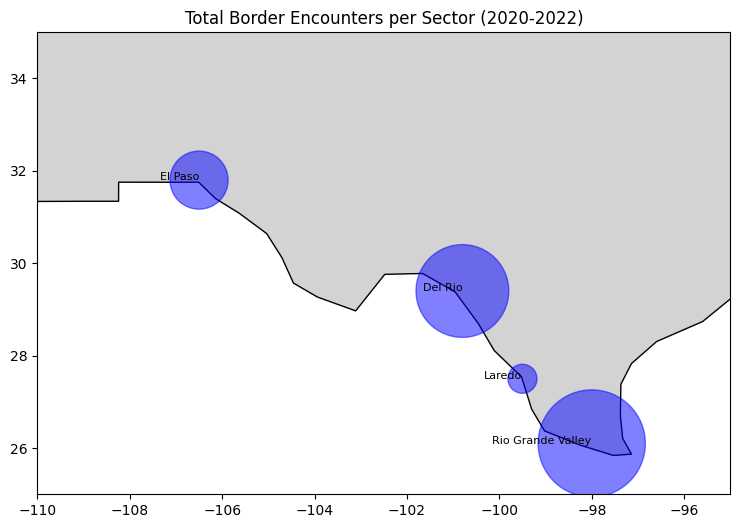

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world shapefile
world = gpd.read_file("/content/drive/MyDrive/0. Job Search 2024/Project/Data/ne_110m_admin_0_countries.shp")

# Check the available columns and country names to ensure we're using the correct filter
print(world.columns)  # Print the available columns
print(world['ADMIN'].unique())  # Check the country names to ensure 'United States' is present

# Example sectors (latitude/longitude manually set based on real-world data)
sector_coords = {
    'Big Bend': [-103.5, 29.7],
    'Del Rio': [-100.8, 29.4],
    'El Paso': [-106.5, 31.8],
    'Laredo': [-99.5, 27.5],
    'Rio Grande Valley': [-98.0, 26.1]
}

# Create a new DataFrame with coordinates
sectors_df = pd.DataFrame.from_dict(sector_coords, orient='index', columns=['Longitude', 'Latitude']).reset_index()
sectors_df.columns = ['Sectors', 'Longitude', 'Latitude']

# Merge encounter data with the coordinates
df_merged = df_filtered.groupby('Sectors').agg({'Encounters': 'sum'}).reset_index()
df_merged = pd.merge(df_merged, sectors_df, on='Sectors')

# Create a GeoDataFrame from this DataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged['Longitude'], df_merged['Latitude']))

# Set the plot to only show the contiguous U.S. region (latitude and longitude bounding box)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the US without Alaska and Hawaii
world[world['ADMIN'] == 'United States of America'].plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot border sectors with size based on encounters
gdf.plot(ax=ax, color='blue', markersize=gdf['Encounters'] / 100, alpha=0.5)

# Zoom in to southern U.S. (approximate bounding box for southern U.S.)
ax.set_xlim([-110, -95])  # Longitude range
ax.set_ylim([25, 35])     # Latitude range

# Optional: Adding labels for each sector
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Sectors']):
    ax.text(x, y, label, fontsize=8, ha='right', color='black')

plt.title('Total Border Encounters per Sector (2020-2022)')
plt.show()


<ipython-input-44-03d2f477c54c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


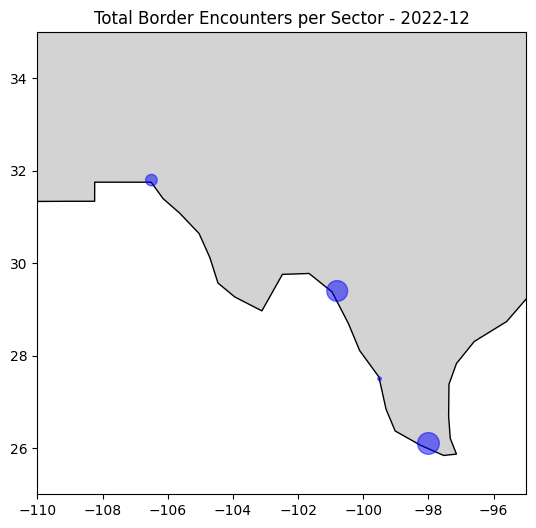

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Load world shapefile manually
world = gpd.read_file("/content/drive/MyDrive/0. Job Search 2024/Project/Data/ne_110m_admin_0_countries.shp")

# Convert the 'Date' column to datetime if not already done
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# Group the data by month and sector, summing up the encounters for each month
df_time_grouped = df_filtered.groupby([pd.Grouper(key='Date', freq='M'), 'Sectors']).agg({'Encounters': 'sum'}).reset_index()

# Create a GeoDataFrame for the sectors with coordinates (use the same sector coordinates as before)
sector_coords = {
    'Big Bend': [-103.5, 29.7],
    'Del Rio': [-100.8, 29.4],
    'El Paso': [-106.5, 31.8],
    'Laredo': [-99.5, 27.5],
    'Rio Grande Valley': [-98.0, 26.1]
}

sectors_df = pd.DataFrame.from_dict(sector_coords, orient='index', columns=['Longitude', 'Latitude']).reset_index()
sectors_df.columns = ['Sectors', 'Longitude', 'Latitude']

# Merge the encounter data with coordinates
df_merged = pd.merge(df_time_grouped, sectors_df, on='Sectors')

# Create a GeoDataFrame from this DataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged['Longitude'], df_merged['Latitude']))

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the base map of the United States
world[world['ADMIN'] == 'United States of America'].plot(ax=ax, color='lightgrey', edgecolor='black')

# Set axis limits to focus on the southern border
ax.set_xlim([-110, -95])
ax.set_ylim([25, 35])

# Initialize a scatter plot for encounters (this will be updated in the animation)
scatter = ax.scatter([], [], s=[], alpha=0.5, color='blue')

# Function to update the scatter plot for each frame
def update(frame):
    current_date = df_merged['Date'].unique()[frame]  # Get the current date
    current_data = df_merged[df_merged['Date'] == current_date]  # Filter data for that date

    # Update scatter plot with new data
    scatter.set_offsets(current_data[['Longitude', 'Latitude']])
    scatter.set_sizes(current_data['Encounters'] / 100)  # Adjust size based on encounters

    # Update the title to reflect the current time period
    ax.set_title(f'Total Border Encounters per Sector - {current_date.strftime("%Y-%m")}')
    return scatter,

# Create the animation, updating every 500ms (adjust interval for speed)
ani = FuncAnimation(fig, update, frames=len(df_merged['Date'].unique()), interval=500, blit=False)

# Save the animation as a gif or mp4 file (adjust path as needed)
ani.save('/content/drive/MyDrive/0. Job Search 2024/Project/Data/border_encounters_animation.gif', writer='imagemagick')

# Alternatively, to show the animation in a Jupyter notebook (remove the save step):
# from IPython.display import HTML
# HTML(ani.to_jshtml())

plt.show()


# Encounters vs Covid, Unemployment Rate

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/0. Job Search 2024/Project/Data/df_final.csv')

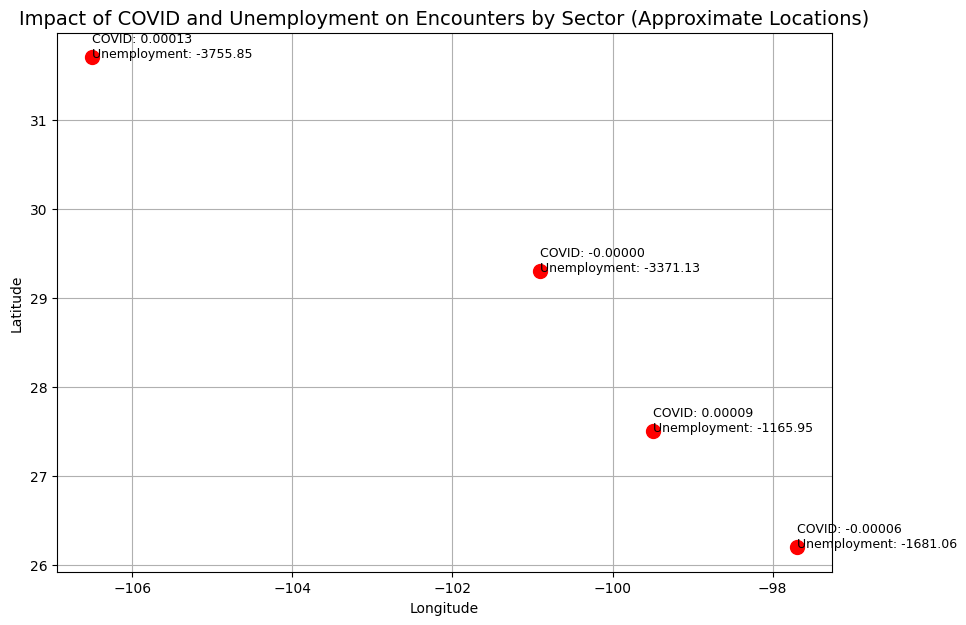

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Clean data: convert Encounters, Mexico_COVID_Cases, and Mexico_Unemployment to numeric
df['Encounters'] = pd.to_numeric(df['Encounters'].str.replace(',', ''), errors='coerce')
df['Mexico_COVID_Cases'] = pd.to_numeric(df['Mexico_COVID_Cases'], errors='coerce')
df['Mexico_Unemployment'] = pd.to_numeric(df['Mexico_Unemployment'], errors='coerce')

# Drop rows with missing values in relevant columns
df_clean = df[['Sectors', 'Encounters', 'Mexico_COVID_Cases', 'Mexico_Unemployment']].dropna()

# Function to perform linear regression and return summary results
def perform_regression(data, sector):
    X = data[['Mexico_COVID_Cases', 'Mexico_Unemployment']]
    X = sm.add_constant(X)  # Add constant for intercept
    y = data['Encounters']

    model = sm.OLS(y, X)
    results = model.fit()

    return results

# Apply the regression to each sector
sectors = df_clean['Sectors'].unique()
regression_results = []

for sector in sectors:
    sector_data = df_clean[df_clean['Sectors'] == sector]
    if len(sector_data) > 0:
        results = perform_regression(sector_data, sector)
        regression_results.append({
            'Sector': sector,
            'Coef_COVID': results.params['Mexico_COVID_Cases'],
            'Coef_Unemployment': results.params['Mexico_Unemployment'],
            'R_squared': results.rsquared
        })

# Convert the results to a DataFrame
df_regression_results = pd.DataFrame(regression_results)

# Calculate the average coefficients
average_coef_covid = df_regression_results['Coef_COVID'].mean()
average_coef_unemployment = df_regression_results['Coef_Unemployment'].mean()

# Plot the sectors on the map (US-Mexico border region)
fig, ax = plt.subplots(figsize=(10, 7))

# Sector locations approximated along the border
sector_locations = {
    'Big Bend': (-104.5, 29.5),
    'Del Rio': (-100.9, 29.3),
    'El Paso': (-106.5, 31.7),
    'Laredo': (-99.5, 27.5),
    'Rio Grande Valley': (-97.7, 26.2),
}

# Plot each sector's location and corresponding average impact value
for sector, loc in sector_locations.items():
    data = df_regression_results[df_regression_results['Sector'] == sector]
    if not data.empty:
        coef_covid = data['Coef_COVID'].values[0]
        coef_unemployment = data['Coef_Unemployment'].values[0]
        ax.scatter(loc[0], loc[1], color='red', s=100, label=sector)
        ax.text(loc[0], loc[1], f"COVID: {coef_covid:.5f}\nUnemployment: {coef_unemployment:.2f}", fontsize=9)

# Set plot title and labels
ax.set_title('Impact of COVID and Unemployment on Encounters by Sector (Approximate Locations)', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.grid(True)
plt.show()

## Impact of COVID-19 Cases on Encounters:

On average, an increase in COVID-19 cases in Mexico results in a small positive effect on the number of encounters in the sectors. However, this impact is minimal, as reflected by the average coefficient of approximately 3.24e-05.
Some sectors, like El Paso, show a slightly stronger positive relationship between COVID-19 cases and encounters, while others, like Rio Grande Valley, show a negative correlation.
Impact of Unemployment on Encounters:

The unemployment rate in Mexico has a significant negative impact on the number of encounters across all sectors. The average coefficient of unemployment is around -2042, meaning that for every percentage increase in the unemployment rate, encounters tend to drop considerably.
This suggests that higher unemployment might reduce the number of people attempting to cross the border, potentially due to economic instability discouraging migration.
Sector-specific Variation:

Different sectors show varying degrees of sensitivity to these factors. For example:
In sectors like El Paso and Laredo, unemployment has a stronger negative effect.
In Big Bend, the impact of unemployment is less pronounced but still negative.
Geographical Insights:

The sectors located along the US-Mexico border experience these effects differently, which may be due to their geographic, social, and economic conditions. Factors like proximity to urban centers or rural regions could contribute to this variation.